# FrameDiPT for TCR CDR3 loop design

FrameDiPT inference can be done by one simple command line
```
python experiments/inference.py \
    inference.name=demo \
    inference.inpainting=True \
    inference.input_aatype=True \
    inference.weights_path=./FrameDiPTModels/weights/inpainting.pth \
    inference.inpainting_samples.data_path=/path/to/the/data.csv \
    inference.inpainting_samples.download_dir=/path/to/download/cif/files
```

While in this notebook, we aim to show step by step how to run FrameDiPT inference to design CDR3 loop in TCR.

## Import library

In [1]:
from __future__ import annotations

import pathlib
from collections import defaultdict

import numpy as np
import omegaconf
import pandas as pd
import torch
import tree

from experiments import utils as exp_utils
from evaluation.evaluate_tcr import (
    parse_diffusion_info,
    parse_diffusion_info_df,
    parse_gt_structures, parse_samples,
    plot_per_residue_graph,
    traverse_prediction_dir,
    update_metrics,
)
from evaluation.utils.constants import EVAL_METRICS
from evaluation.utils.plot import swarmplot_metrics_alpha_beta
from evaluation.utils.sample_selection import (
    get_model_diffused_region_coords,
    mode_sample,
)
from framedipt.analysis import utils as analysis_utils
from framedipt.data import utils as data_utils
from framedipt.data import process_pdb_dataset
from framedipt.diffusion import se3_diffuser
from framedipt.model import score_network
from framedipt.protein import tcr, all_atom
from framedipt.tools.log import get_logger
from openfold.utils import rigid_utils

/home/cheng-zhang/mambaforge/envs/framedipt-env/lib/python3.9/site-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [2]:
# Define inference metadata
device = "cpu"  # Change to cuda if gpu is available on your system
exp_name = "demo"
output_dir = pathlib.Path(f"./inference_outputs/{exp_name}")
weights_path = pathlib.Path("../FrameDiPTModels/weights/inpainting.pth")

logger = get_logger()

## Download mmCIF files

We first need to download TCR structures from [RCSB PDB](https://www.rcsb.org/). In this demo, we just download a few TCR samples for each group: 
- TCR (2bnu, 1kgc, 2ial)
- TCR:pMHC-I (2bnq, 1mi5)
- TCR:pMHC-II (2ian)

We chose paired structures for the same TCR in unbound and bound states `{2bnu:2bnq; 1kgc:1mi5; 2ial:2ian}` to show the different predictions from our model in different binding states.

We prepared a csv file `./examples.csv` containing these samples and the corresponding chain identification for TCR, peptide and MHC.

In [3]:
samples = pd.read_csv("./examples.csv")
samples.head

<bound method NDFrame.head of   pdb_id tcr_alpha_chain tcr_beta_chain mhc_alpha_chain mhc_beta_chain  \
0   1kgc               D              E             NaN            NaN   
1   2ial               A              B             NaN            NaN   
2   2bnu               A              B             NaN            NaN   
3   2bnq               D              E               A              B   
4   1mi5               D              E               A              B   
5   2ian               D              E               A              B   

  peptide_chain  
0           NaN  
1           NaN  
2           NaN  
3             C  
4             C  
5             C  >

In [4]:
# Define download path
download_dir = pathlib.Path("./samples")
# Download first assembly mmCIF files
data_utils.download_cifs(
    pdb_codes=samples["pdb_id"].to_numpy(),
    outdir=download_dir,
    assembly=True,
)

I1122 17:31:20.916887 140463130832640 utils.py:149] mmCif files are downloaded to samples/cifs.


Structure exists: 'samples/cifs/1kgc-assembly1.cif' 
Structure exists: 'samples/cifs/2bnu-assembly1.cif' 
Structure exists: 'samples/cifs/2bnq-assembly1.cif' 
Structure exists: 'samples/cifs/2ial-assembly1.cif' 
Structure exists: 'samples/cifs/2ian-assembly1.cif' 
Structure exists: 'samples/cifs/1mi5-assembly1.cif' 


We can check that the corresponding files are downloaded to `./samples/cifs`. If it's not the case, e.g. some files are missing, please rerun the above cell to complete the download.

## Pre-process mmCIF files

Now we need to pre-process the downloaded mmCIF files in order to prepare the dataset for inference. The processed pickle files will be saved under `./samples/processed` with a csv file `metadata.csv` containing the metadata of the processed files.

In [5]:
def get_chains_to_process(
    df_samples: pd.DataFrame,
    pdb_files: list[pathlib.Path],
) -> list[list[str]] | list[None]:
    """Get chains to process for the whole TCR dataset.

    For each TCR sample, according to whether it's bound to pMHC,
        we may have the following options to process.
            - 2 chains (TCR alpha and beta);
            - 4 chains (TCR alpha and beta, peptide, MHC-I chain);
            - 5 chains (TCR alpha and beta, peptide, MHC-II alpha and beta).

    Returns:
        List of chain lists to process for each tcr sample.
    """
    all_chains_to_process = []
    for pdb_file in pdb_files:
        # Find the example in the dataframe corresponding to pdb file.
        pdb_id = pdb_file.stem

        # Note first assembly files are of the format {pdb_id}-assembly1.cif, not
        # {pdb_id}.cif.
        pdb_id = pdb_id[:4]

        example = df_samples[df_samples["pdb_id"] == pdb_id].iloc[0]
        # Get TCR alpha and beta chain ids.
        tcr_alpha_chain = example["tcr_alpha_chain"]
        tcr_beta_chain = example["tcr_beta_chain"]
        chains = [tcr_alpha_chain, tcr_beta_chain]
        # Get pMHC chains if there is any.
        if example["peptide_chain"] is not None and isinstance(
            example["peptide_chain"], str
        ):
            chains.append(example["peptide_chain"])
        if example["mhc_alpha_chain"] is not None and isinstance(
            example["mhc_alpha_chain"], str
        ):
            chains.append(example["mhc_alpha_chain"])
        if example["mhc_beta_chain"] is not None and isinstance(
            example["mhc_beta_chain"], str
        ):
            chains.append(example["mhc_beta_chain"])

        all_chains_to_process.append(chains)
    return all_chains_to_process

pdb_files = list((download_dir / "cifs").glob("*.cif"))
all_chains_to_process = get_chains_to_process(df_samples=samples, pdb_files=pdb_files)
all_metadata = process_pdb_dataset.process_serially(
    all_mmcif_paths=pdb_files,
    max_resolution=None,
    max_len=None,
    min_len=None,
    chain_max_len=None,
    chain_min_len=None,
    max_num_chains=None,
    write_dir=download_dir / "processed",
    all_chains_to_process=all_chains_to_process,
    check_valid_resolution=False,
)
metadata = pd.DataFrame(all_metadata)
metadata_path = download_dir / "processed/metadata.csv"
metadata.to_csv(metadata_path, index=False)

I1122 17:31:23.116826 140463130832640 process_pdb_dataset.py:499] Processing samples/cifs/1mi5-assembly1.cif.
W1122 17:31:23.244450 140463130832640 mmcif_parsing.py:329] Could not determine release_date: ['XXXX']
I1122 17:31:23.614810 140463130832640 process_pdb_dataset.py:626] Finished samples/cifs/1mi5-assembly1.cif in 0.50s.
I1122 17:31:23.615416 140463130832640 process_pdb_dataset.py:499] Processing samples/cifs/2bnq-assembly1.cif.
W1122 17:31:23.745251 140463130832640 mmcif_parsing.py:329] Could not determine release_date: ['XXXX']
I1122 17:31:24.221869 140463130832640 process_pdb_dataset.py:626] Finished samples/cifs/2bnq-assembly1.cif in 0.61s.
I1122 17:31:24.222360 140463130832640 process_pdb_dataset.py:499] Processing samples/cifs/1kgc-assembly1.cif.
W1122 17:31:24.300619 140463130832640 mmcif_parsing.py:329] Could not determine release_date: ['XXXX']
I1122 17:31:24.396982 140463130832640 process_pdb_dataset.py:379] Renaming chains so that MDtraj can load samples/cifs/1kgc-ass

## Create Dataset

Now we can define the TCRSampler class to prepare the Dataset.

In [6]:
# Define TCRSample class
class TCRSampler(torch.utils.data.Dataset):
    """Sampler class for inpainting validation on TCR dataset.

    It inherits torch.utils.data.Dataset.
    """

    def __init__(
        self,
        data_conf: omegaconf.DictConfig,
        diffuser: se3_diffuser.SE3Diffuser,
        device: str,
        metadata: pd.DataFrame,
        all_chains_to_process: list[list[str]] | list[None],
    ) -> None:
        """Init function.

        Args:
            data_conf: dataset configuration.
            diffuser: object of SE3Diffuer to perform diffusion.
            device: device to use, e.g. "cpu", "cuda:0".
            metadata: pandas Dataframe containing the metadata
                generated during data processing.
            all_chains_to_process: List of chain lists to process
                for each tcr sample.
        """
        self.data_conf = data_conf
        self.diffuser = diffuser
        self.device = device
        self.diffused_masks: dict[int, np.ndarray] = {}
        self.rng = np.random.default_rng(self.data_conf.seed)
        self.metadata = metadata
        self.all_chains_to_process = all_chains_to_process

    def create_diffusion_mask(
        self,
        chain_feats: dict[str, np.ndarray | torch.Tensor],
        example_idx: int,
    ) -> np.ndarray:
        """Create diffusion mask, overriding the one in ConditionalSampler.

        CDR3 loops in TCR alpha and beta chain are masked for diffusion.

        Args:
            chain_feats: dictionary of processed chain features.
            example_idx: index of the example in the dataset.

        Returns:
            The diffusion mask.
            If example_idx already exists in self.diffused_masks,
                the pre-computed diffused mask will be returned.
            This reduces unnecessary compute.

        Raises:
            ValueError if the chains to process for the sample is None
                or cdr_loops is not given in the data config.
        """
        if self.diffused_masks.get(example_idx) is not None:
            return self.diffused_masks[example_idx]

        chains_to_process = self.all_chains_to_process[example_idx]
        if chains_to_process is None:
            raise ValueError("Should have chains to process for TCRSampler, got None.")
        if self.data_conf.cdr_loops is None or len(self.data_conf.cdr_loops) == 0:
            raise ValueError("CDR loops should be given in the config.")

        diffused_mask = tcr.create_diffusion_mask(
            chain_indexes=chain_feats["chain_idx"],
            aatype=data_utils.move_to_np(chain_feats["aatype"]),
            tcr_chains=chains_to_process[:2],
            cdr_loops=self.data_conf.cdr_loops,
            shifted_region=self.data_conf.shifted_region,
        )
        self.diffused_masks[example_idx] = diffused_mask

        return diffused_mask
    
    def __len__(self) -> int:
        """Get length of the dataset.

        Returns:
            Length of the dataset, i.e. the total number of samples to be generated.
        """
        return len(self.metadata) * self.data_conf.num_samples

    def __getitem__(self, idx: int) -> tuple[str, int, dict[str, torch.Tensor]]:
        """Get item of the dataset.

        Args:
            idx: index of the item in the dataset.

        Returns:
            Dictionary of features or optional pdb name.
                - aatype: amino acid types, shape [Batch, N_res, 21].
                - seq_idx: 0-based residue indices, shape [Batch, N_res].
                - chain_idx: chain indices, shape [Batch, N_res].
                - residx_atom14_to_atom37: indices to convert atom14 to atom 37,
                    shape [Batch, N_res, 14].
                - residue_index: raw residue indices in PDB file,
                    shape [Batch, N_res].
                - res_mask: residue mask, shape [Batch, N_res].
                - atom37_pos: atom37 coordinates, shape [Batch, N_res, 37, 3].
                - atom37_mask: atom37 mask, shape [Batch, N_res, 37].
                - atom14_pos: atom14 coordinates, shape [Batch, N_res, 14, 3].
                - rigidgroups_0: rigid group representation at t = 0,
                    shape [Batch, N_res, 8, 4, 4].
                - torsion_angles_sin_cos: torsion angle in sin-cos format,
                    shape [Batch, N_res, 7, 2].
                - fixed_mask: mask for fixed residues, shape [Batch, N_res].
                - rigids_0: rigid representation at t = 0,
                    shape [Batch, N_res, 7].
                - sc_ca_t: carbon-alpha coordinates used for self-conditioning,
                    shape [Batch, N_res, 3].
                - rigids_t: rigid representation at timestep t,
                    shape [Batch, N_res, 7].
                - t: timestep t, shape [Batch].
        """
        # Sample data example.
        example_idx = idx // self.data_conf.num_samples
        sample_idx = idx % self.data_conf.num_samples
        csv_row = self.metadata.iloc[example_idx]
        pdb_name = csv_row["pdb_name"]
        processed_file_path = pathlib.Path(csv_row["processed_path"])
        chain_feats = data_utils.process_csv_row(
            processed_file_path,
            process_monomer=False,
            extract_single_chain=False,
            rng=self.rng,
        )

        gt_bb_rigid = rigid_utils.Rigid.from_tensor_4x4(chain_feats["rigidgroups_0"])[
            :, 0
        ]

        diffused_mask = self.create_diffusion_mask(
            chain_feats=chain_feats, example_idx=example_idx
        )

        if np.sum(diffused_mask) < 1:
            raise ValueError("Must be diffused")
        fixed_mask: np.ndarray = 1 - diffused_mask
        chain_feats["fixed_mask"] = fixed_mask
        chain_feats["rigids_0"] = gt_bb_rigid.to_tensor_7()
        chain_feats["sc_ca_t"] = torch.zeros_like(gt_bb_rigid.get_trans())

        # Fix t to final timestep 1.0
        # and sample from reference distribution and diffuse.
        t = 1.0
        diff_feats_t = self.diffuser.sample_ref(
            n_samples=gt_bb_rigid.shape[0],
            chain_index=chain_feats["chain_idx"],
            impute=gt_bb_rigid,
            diffuse_mask=diffused_mask,
            as_tensor_7=True,
        )

        chain_feats.update(diff_feats_t)
        chain_feats["t"] = t

        # Convert all features to tensors.
        final_feats = tree.map_structure(
            lambda x: x if torch.is_tensor(x) else torch.tensor(x), chain_feats
        )

        # Pad features
        final_feats = data_utils.pad_feats(
            final_feats, csv_row["modeled_seq_len"], use_torch=True
        )

        # Add batch dimension and move to GPU.
        final_feats = tree.map_structure(lambda x: x[None].to(self.device), final_feats)

        return pdb_name, sample_idx, final_feats

In [7]:
# Define dataset config
data_conf = omegaconf.OmegaConf.create(
    {
        "cdr_loops": ["CDR3"],
        "shifted_region": None,
        "num_samples": 3,
        "seed": 123,
    }
)
# Initialize SE(3) diffuser
diffuser_conf = omegaconf.OmegaConf.create(
    {
        "diffuse_trans": True,
        "diffuse_rot": True,
        
        # R(3) diffuser arguments
        "r3":
            {
                "min_b": 0.1,
                "max_b": 20.0,
                "coordinate_scaling": 0.1,
                "seed": None,
            },
        
        # SO(3) diffuser arguments
        "so3":
            {
                "num_omega": 1000,
                "num_sigma": 1000,
                "min_sigma": 0.1,
                "max_sigma": 1.5,
                "schedule": "logarithmic",
                "cache_dir": ".cache/",
                "use_cached_score": False,
                "seed": None,
            },
    }
)
diffuser = se3_diffuser.SE3Diffuser(diffuser_conf)

# Initialize TCR sampler
sampler = TCRSampler(
    data_conf=data_conf,
    diffuser=diffuser,
    device=device,
    metadata=metadata,
    all_chains_to_process=all_chains_to_process,
)

I1122 17:31:27.970846 140463130832640 so3_diffuser.py:243] Using cached IGSO3 in .cache/eps_1000_omega_1000_min_sigma_0_1_max_sigma_1_5_schedule_logarithmic


## Initialize model

We need to initialize our inpainting model before running inference.

In [8]:
# Define model config
model_conf = omegaconf.OmegaConf.create(
    {
        "input_aatype": True,
        "node_embed_size": 256,
        "edge_embed_size": 128,
        "dropout": 0.0,
        "embed": 
            {
                "index_embed_size": 32,
                "aatype_embed_size": 64,
                "embed_self_conditioning": True,
                "num_bins": 22,
                "min_bin": 1e-5,
                "max_bin": 20.0,
            },
        "ipa":
            {
                "c_s": 256,
                "c_z": 128,
                "c_hidden": 256,
                "c_skip": 64,
                "no_heads": 8,
                "no_qk_points": 8,
                "no_v_points": 12,
                "seq_tfmr_num_heads": 4,
                "seq_tfmr_num_layers": 2,
                "num_blocks": 4,
                "coordinate_scaling": diffuser_conf.r3.coordinate_scaling,
            },
    }
)

# Initialize model
model = score_network.ScoreNetwork(
    model_conf=model_conf,
    diffuser=diffuser,
    inpainting=True,
)

# Read checkpoint
weights_pkl = data_utils.read_pkl(
    weights_path, use_torch=True, map_location=device
)

# Remove module prefix if it exists
model_weights = weights_pkl["model"]
model_weights = {k.replace("module.", ""): v for k, v in model_weights.items()}
model.load_state_dict(model_weights)
model = model.to(device)
model.eval()

ScoreNetwork(
  (embedding_layer): Embedder(
    (node_embedder): Sequential(
      (0): Linear(in_features=86, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (edge_embedder): Sequential(
      (0): Linear(in_features=162, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (score_model): IpaScore(
    (trunk): ModuleDict(
      (ipa_0): InvariantPointAttention(
        (linear_q): Linear(in_features=256, out_features=2048, bias=True)
        (linear_kv): Linear(in_features=256, out_features=4096, bias=True)
        (linear_q_points): Linear(in_features=2

## Run inference

In [9]:
# Define inference utility functions
def save_traj(
    bb_prot_traj: np.ndarray,
    x0_traj: np.ndarray,
    diffuse_mask: np.ndarray,
    output_dir: pathlib.Path | str,
    sample_idx: int,
    aatype: np.ndarray | None = None,
    residue_index: np.ndarray | None = None,
    chain_index: np.ndarray | None = None,
    save_backbone_trajectory: bool = False,
    save_pred_x0_trajectory: bool = False,
) -> dict[str, pathlib.Path]:
    """Writes final sample and reverse diffusion trajectory.

    Args:
        bb_prot_traj: [T, N, 37, 3] atom37 sampled diffusion states.
            T is number of time steps. First time step is t=eps,
            i.e. bb_prot_traj[0] is the final sample after reverse diffusion.
            N is number of residues.
        x0_traj: [T, N, 3] x_0 predictions of C-alpha at each time step.
        diffuse_mask: [N] which residues are diffused.
        output_dir: where to save samples.
        sample_idx: index of generated samples for the test case.
        aatype: AA type, used in case of inpainting.
        residue_index: residue indices, used in case of inpainting.
        chain_index: chain indices, used in case of inpainting.

    Returns:
        Dictionary with paths to saved samples:
            - "sample_path": PDB file of final state of reverse trajectory.
            - "traj_path": PDB file of all intermediate diffused states.
            - "x0_traj_path": PDB file of C-alpha x_0 predictions at each state.
        b_factors are set to 100 for diffused residues and 0 for motif
            residues if there are any.
    """
    if isinstance(output_dir, str):
        output_dir = pathlib.Path(output_dir)

    # Write sample.
    diffuse_mask = diffuse_mask.astype(bool)
    sample_path = output_dir / f"sample_{sample_idx}"
    prot_traj_path = output_dir / f"bb_traj_{sample_idx}"
    x0_traj_path = output_dir / f"x0_traj_{sample_idx}"

    # Use b-factors to specify which residues are diffused.
    b_factors = np.tile((diffuse_mask * 100)[:, None], (1, 37))

    sample_path = analysis_utils.write_prot_to_pdb(
        bb_prot_traj[0],
        sample_path,
        b_factors=b_factors,
        aatype=aatype,
        residue_index=residue_index,
        chain_index=chain_index,
    )
    if save_backbone_trajectory:
        prot_traj_path = analysis_utils.write_prot_to_pdb(
            bb_prot_traj,
            prot_traj_path,
            b_factors=b_factors,
            aatype=aatype,
            residue_index=residue_index,
            chain_index=chain_index,
        )
    if save_pred_x0_trajectory:
        x0_traj_path = analysis_utils.write_prot_to_pdb(
            x0_traj,
            x0_traj_path,
            b_factors=b_factors,
            aatype=aatype,
            residue_index=residue_index,
            chain_index=chain_index,
        )
    return {
        "sample_path": sample_path,
        "traj_path": prot_traj_path,
        "x0_traj_path": x0_traj_path,
    }

In [10]:
inference_conf = omegaconf.OmegaConf.create(
    {
        "diffusion":
            {
                "num_t": 100,
                "min_t": 0.01,
                "noise_scale": 0.1,
            },
    }
)

In [10]:
for pdb_name, sample_i, sample_feats in sampler:
    gt_prot = exp_utils.get_atom_positions_from_rigids(
        rigids=rigid_utils.Rigid.from_tensor_7(sample_feats["rigids_0"]),
        psi_torsions=sample_feats["torsion_angles_sin_cos"][..., 2, :],
        aatype=sample_feats["aatype"],
    )
    res_mask = data_utils.move_to_np(sample_feats["res_mask"].bool())
    fixed_mask = data_utils.move_to_np(sample_feats["fixed_mask"].bool())
    res_mask_sum: np.ndarray = np.sum(res_mask)
    num_res = res_mask_sum.item()
    diffused_length = num_res - np.sum(fixed_mask * res_mask)
    diffused_mask = (1 - fixed_mask) * res_mask
    aatype = data_utils.move_to_np(sample_feats["aatype"])
    seq = data_utils.aatype_to_seq(aatype[res_mask])
    residue_index = data_utils.move_to_np(sample_feats["residue_index"])
    chain_index = data_utils.move_to_np(sample_feats["chain_idx"])

    # Set up length directory, top 1 level
    length_dir = output_dir / f"{pdb_name}_length_{diffused_length}"
    length_dir.mkdir(parents=True, exist_ok=True)
    logger.info(f"Sampling length {diffused_length}: {length_dir}")

    # Save ground truth to pdb file.
    gt_pdb_path = length_dir / f"{pdb_name}_1.pdb"
    if not gt_pdb_path.exists():
        # Save ground truth to pdb file.
        # Use b-factors to specify which residues are diffused.
        b_factors = np.tile(
            (diffused_mask.astype(bool) * 100)[..., None], (1, 1, 37)
        )
        analysis_utils.write_prot_to_pdb(
            prot_pos=gt_prot[res_mask],
            file_path=length_dir / pdb_name,
            aatype=aatype[res_mask],
            b_factors=b_factors[res_mask],
            residue_index=residue_index[res_mask],
            chain_index=chain_index[res_mask],
        )

    # Save diffusion info to csv file.
    diffusion_info_path = length_dir / "diffusion_info.csv"
    if not diffusion_info_path.exists():
        exp_utils.save_diffusion_info(
            output_dir=length_dir,
            pdb_name=pdb_name,
            seq=seq,
            diffused_mask=diffused_mask[res_mask],
            chain_index=chain_index[res_mask],
        )

    # Set up sample directory, top 2 level
    sample_dir = length_dir / f"sample_{sample_i}"
    if sample_dir.exists():
        continue
    sample_dir.mkdir(parents=True, exist_ok=True)

    # Run inference
    sample_output = exp_utils.inference_fn(
        model=model,
        diffuser=diffuser,
        data_init=sample_feats,
        num_t=inference_conf.diffusion.num_t,
        min_t=inference_conf.diffusion.min_t,
        noise_scale=inference_conf.diffusion.noise_scale,
        aux_traj=True,
        embed_self_conditioning=model_conf.embed.embed_self_conditioning,
        inpainting=True,
        input_aatype=True,
    )
    sample_output = tree.map_structure(lambda x: x[:, 0], sample_output)

    # Save inference trajectory
    traj_paths = save_traj(
        sample_output["prot_traj"][:, res_mask[0]],
        sample_output["rigid_0_traj"][:, res_mask[0]],
        diffused_mask[res_mask],
        output_dir=sample_dir,
        sample_idx=sample_i,
        aatype=aatype[res_mask],
        residue_index=residue_index[res_mask],
        chain_index=chain_index[res_mask],
    )

    pdb_path = traj_paths["sample_path"]
    logger.info(f"Done sample {sample_i}: {pdb_path}")

I1122 13:41:00.939327 140264100617984 4188273708.py:32] Sampling length 25: inference_outputs/demo/1mi5-assembly1_length_25
I1122 13:41:00.956743 140264100617984 4188273708.py:32] Sampling length 25: inference_outputs/demo/1mi5-assembly1_length_25
/home/cheng-zhang/mambaforge/envs/framedipt-env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:276: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/NestedTensorImpl.cpp:175.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/home/cheng-zhang/Workspace/sources/sources/paper/framedipt/framedipt/diffusion/r3_diffuser.py:407: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 1 - torch.e

KeyboardInterrupt: 

## Visualize results

Inference results will be saved to `./inference_outputs/demo`. For each TCR sample, a folder with name `{pdb_id}-assembly1_length_{diffused_length}` will be created with `{pdb_id}-assembly1_1.pdb` for the processed ground truth structure and `diffusion_info.csv` for the diffusion information therein. For each inpainted sample, one folder with name `sample_{sample_idx}` will be created.

In [11]:
# install py3Dmol for visualization
! pip install py3Dmol ipywidgets
! jupyter labextension install jupyterlab_3dmol

Building jupyterlab assets (production, minimized)


In [12]:
from ipywidgets import interact
import py3Dmol

In [13]:
# Copied from ColabFold
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

In [14]:
def show_gt_model(pdb_id):
    view = py3Dmol.view(js="https://3dmol.org/build/3Dmol.js",)
    for pdb_folder in output_dir.glob(f"{pdb_id}-assembly1_length_*"):
        gt_pdb = pdb_folder / f"{pdb_id}-assembly1_1.pdb"
        gt_model = data_utils.read_pdb(gt_pdb, pdb_id)
        chains = gt_model.child_dict.keys()
        view.addModel(open(gt_pdb, "r").read(), "pdb")
        for chaini, chain in enumerate(chains):
            view.setStyle(
                {"chain": chain}, 
                {"cartoon": {"color": pymol_color_list[chaini]}}
            )
    view.zoomTo()
    return view

In [15]:
def show_sample_model(pdb_id, idx):
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
    for pdb_folder in output_dir.glob(f"{pdb_id}-assembly1_length_*"):
        diffusion_info_csv = pdb_folder / "diffusion_info.csv"
        diffusion_info_df = pd.read_csv(diffusion_info_csv, sep="\t")
        _, diffused_chains, starts, ends = parse_diffusion_info_df(
            df=diffusion_info_df,
            cdr_loop_index=0,
        )
        gt_pdb = pdb_folder / f"{pdb_id}-assembly1_1.pdb"
        gt_model = data_utils.read_pdb(gt_pdb, pdb_id)
        chains = gt_model.child_dict.keys()
        sample_folder = pdb_folder / f"sample_{idx}"
        sample_pdb = sample_folder / f"{sample_folder.stem}_1.pdb"
        view.addModel(open(sample_pdb, "r").read(), "pdb")
    
    residue_color = pymol_color_list[-1 - idx]
    for chaini, chain in enumerate(chains):
        residues = [res for res in gt_model[chain].get_residues()]
        colors = [pymol_color_list[chaini] for resi, res in enumerate(residues)]
        if chain in diffused_chains:
            for resi in range(starts[chaini], ends[chaini] + 1):
                colors[resi] = residue_color
        view.setStyle(
            {"chain": chain}, 
            {"cartoon": 
                {"colorscheme": 
                    {"prop":"resi", "map": colors}
                }
            }
        )
    
    view.zoomTo()
    return view

In [16]:
# Select a random pdb id
pdb_ids = samples["pdb_id"].to_numpy()
pdb_id = np.random.choice(pdb_ids)
print(pdb_id)

1kgc


Show the ground truth structure

In [19]:
show_gt_model(pdb_id)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Show FrameDiPT generated samples. By slicing over the `idx`, we can see different CDR3 loops are generated (colored differently with chain colors).

In [18]:
interact(show_sample_model, pdb_id=pdb_id, idx=(0, data_conf.num_samples - 1))

interactive(children=(Text(value='1kgc', description='pdb_id'), IntSlider(value=2, description='idx', max=4), …

<function __main__.show_sample_model(pdb_id, idx)>

## Select representative sample and compute RMSD

We developed a sample selection strategy based on kernel density estimation. A Gaussian kernel is fitted over carbon alpha coordinates of the inpainted region and the sample with the highest density is selected as the "most-like" sample to evaluate the Root-Mean-Square-Deviation(RMSD).

The evaluation can be done with the following command line.
```
python evaluation/evaluate_tcr.py \
    inference_path=/path/to/inference/results \
    eval_output_path=/path/to/save/evaluation/results
```

Here we show how to do the evaluation step by step.

In [20]:
# Define evaluation metadata
inference_path = output_dir
eval_output_path = pathlib.Path("./eval_demo")
eval_output_path.mkdir(parents=True, exist_ok=True)

metric_cfg = omegaconf.OmegaConf.create(
    {
        # metrics defined per model
        "model_metrics": ["bb_rmsd"],
        # metrics defined per chain
        "chain_metrics": ["bb_rmsd"],
        # metrics defined per residue
        "residue_metrics": ["bb_rmsd"],
        # metrics with more than one result per residue
        # For example, angle_error has phi, psi and omega angle metrics
        "residue_group_metrics": [],
    }
)

Parse inference results directory.

In [ ]:
# Traverse prediction directory
prediction_info_dict = traverse_prediction_dir(
    inference_path=inference_path,
    legacy_file_structure=False,
)

# Parse ground-truth structures.
pdb_ids = prediction_info_dict["pdb_ids"]
gt_pdb_paths = prediction_info_dict["gt_pdb_paths"]
# List of shape (n_pdb_ids).
gt_models = parse_gt_structures(pdb_ids, gt_pdb_paths)

# Parse predicted structures.
predicted_pdb_paths = prediction_info_dict["predicted_pdb_paths"]
# List of shape (n_pdb_ids, n_samples).
predicted_models = parse_samples(pdb_ids, predicted_pdb_paths)

# Parse diffusion info csv file
diffusion_info_paths = prediction_info_dict["diffusion_info_paths"]
diffusion_info_dict = parse_diffusion_info(
    diffusion_info_paths, cdr_loop_index=0,
)

Define the kernel density estimation strategy for sample selection.

In [21]:
def get_selected_model(
    predicted_models: list[Model.Model],
    predicted_pdb_paths: list[pathlib.Path],
    starts: Sequence[int],
    ends: Sequence[int],
    chains: list[str],
) -> dict[str, Model.Model | pathlib.Path]:
    """Get selected model according to mode sample selection strategy.

    Args:
        predicted_models: iterable of biopython models of predicted structures.
        predicted_pdb_paths: list of corresponding pdb paths.
        starts: start indices of the diffused region. Shape (n_diffused_regions).
        ends: end indices of the diffused region. Shape (n_diffused_regions).
        chains: chains in diffused region. Shape (n_diffused_regions).

    Returns:
        Dictionary of selected model and path.
    """
    # Get sample diffused region coordinates
    sample_diffused_region_coords_lists = defaultdict(list)
    for sample_model in predicted_models:
        sample_diffused_region_coords = get_model_diffused_region_coords(
            model=sample_model,
            chain_ids=chains,
            diffused_regions=list(zip(starts, ends)),
        )
        for chain_id, diffused_region_coords in sample_diffused_region_coords.items():
            sample_diffused_region_coords_lists[chain_id].append(diffused_region_coords)
    sample_diffused_region_coords = {
        k: np.stack(v, axis=0) for k, v in sample_diffused_region_coords_lists.items()
    }
    
    model, path = mode_sample(
        starts=starts,
        ends=ends,
        chains=chains,
        sample_diffused_region_coords=sample_diffused_region_coords,
        predicted_models=predicted_models,
        predicted_pdb_paths=predicted_pdb_paths,
    )
    
    selected_model = {
        "model": model,
        "path": path,
    }
    
    return selected_model

Run evaluation over the inference results.

In [22]:
dataset_info = (
    pdb_ids,
    diffusion_info_dict["diffused_sequences"],
    diffusion_info_dict["diffused_start_indices"],
    diffusion_info_dict["diffused_end_indices"],
    gt_models,
    predicted_models,
    predicted_pdb_paths,
    diffusion_info_dict["diffused_chains"],
)
all_metrics = []
for pdb_data in zip(*dataset_info):
    # Get information associated with the current pdb
    (
        pdb_id,
        seq,
        starts,
        ends,
        gt_model,
        predicted_model,
        predicted_pdb_path,
        chains,
    ) = pdb_data

    predicted_model = list(predicted_model)

    selected_model = get_selected_model(
        predicted_models=predicted_model,
        predicted_pdb_paths=predicted_pdb_path,
        starts=starts,
        ends=ends,
        chains=chains,
    )
    
    metrics: dict[str, Any] = {
        "pdb_name": pdb_id,
        "structure_length": len(seq),
        "tcr_alpha_chain": chains[0],
        "tcr_beta_chain": chains[1],
        "tcr_alpha_chain_start_idx": starts[0],
        "tcr_alpha_chain_end_idx": ends[0],
        "tcr_alpha_chain_diffused_length": ends[0] - starts[0] + 1,
        "tcr_beta_chain_start_idx": starts[1],
        "tcr_beta_chain_end_idx": ends[1],
        "tcr_beta_chain_diffused_length": ends[1] - starts[1] + 1,
    }
    
    diffusion_region = list(zip(starts, ends))
    
    metrics = update_metrics(
        metrics=metrics,
        metric_cfg=metric_cfg,
        sample_path=selected_model["path"],
        gt_model=gt_model,
        sample_model=selected_model["model"],
        chains=chains,
        diffusion_region=diffusion_region,
    )
    all_metrics.append(metrics.copy())

df_metrics= pd.DataFrame(all_metrics)
df_metrics.to_csv(eval_output_path / "eval_metrics_mode.csv", index=False, sep="\t")

Evaluation metrics are saved to `./eval_demo/eval_metrics_mode.csv`, now we can plot the evaluation results.

I1122 17:33:16.002647 140463130832640 category.py:234] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I1122 17:33:16.005947 140463130832640 category.py:234] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


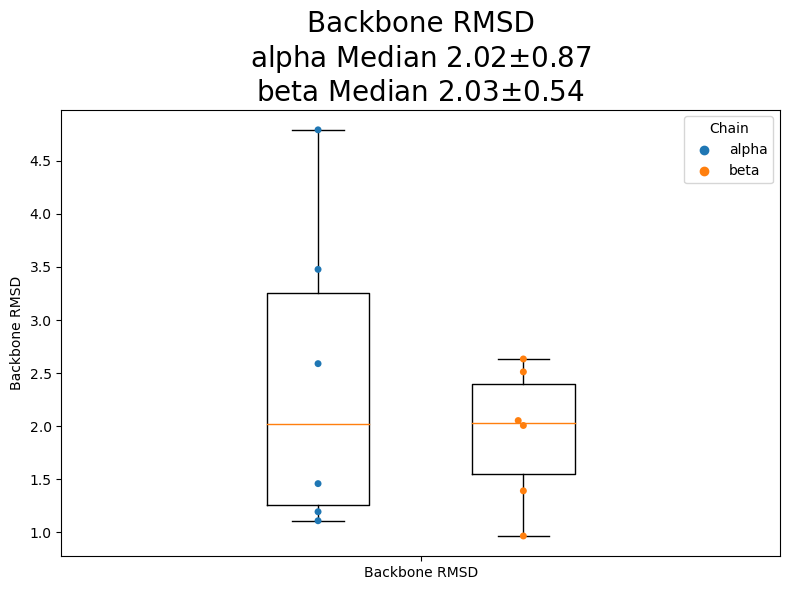

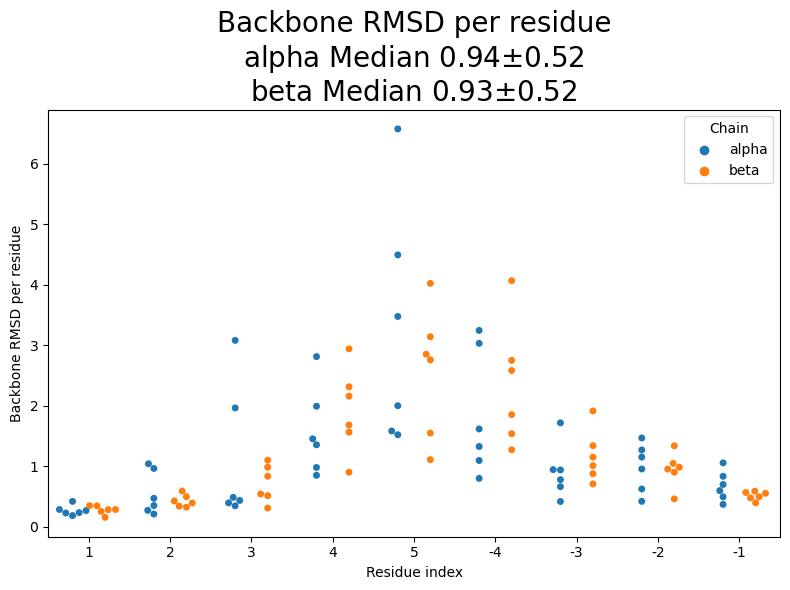

In [23]:
bb_rmsds_alpha = df_metrics["bb_rmsd_alpha"].to_numpy()
bb_rmsds_beta = df_metrics["bb_rmsd_beta"].to_numpy()

swarmplot_metrics_alpha_beta(
    metrics_alpha=[bb_rmsds_alpha],
    metrics_beta=[bb_rmsds_beta],
    eval_output_path=eval_output_path,
    legend="Backbone RMSD",
    xticks=["Backbone RMSD"],
    superpose_box=True,
)

for metric in metric_cfg.residue_metrics:
    plot_per_residue_graph(
        df_metrics=df_metrics,
        eval_output_path=eval_output_path,
        legend=EVAL_METRICS[metric],
        metric=metric,
        swarmplot=True,
    )

## Conclusions

FrameDiPT is an SE(3) diffusion model for protein structure inpainting. While testing on TCR CDR3 loop design, we get promising results, with a median backbone RMSD ~2Å. Diverse CDR3 loops have been generated, demonstrating the generative capability of diffusion models.